In [1]:
using Distributions
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!
using Base.Iterators: repeated, partition
using LinearAlgebra: norm
using CounterfactualExplanations
using Distances
using BSON
using MLDatasets

include("../src/utils/train.jl")
include("../src/utils/plot.jl")
include("../src/utils/evaluate.jl")

evaluate_model (generic function with 1 method)

In [2]:
X, y = load_mnist()
X = (X .+ 1) ./ 2

784×60000 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [3]:
X = reshape(X, 28, 28, 1, 60000)

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [4]:
X

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [5]:
size(X)

(28, 28, 1, 60000)

In [6]:
X_basic, y_basic = TaijaData.load_mnist()
X_basic = (X_basic .+ 1) ./ 2
m = BSON.load("../src/models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson")[:adv_pgd_strong]
clean_m = BSON.load("../src/models/MNIST/clean_20ep_32bs.bson")[:model]
X_sample = X_basic[:, 100:105]
y_sample = y_basic[100:105]
y_onehot = onehotbatch(y_sample, 0:9)
logits = m(X_sample)

10×6 Matrix{Float32}:
 -13.0563   -4.86521   -5.03296  -17.0138    -8.03976  -17.0315
   4.4687   -5.77479   -9.36942    4.96197   -6.15806    4.63923
  -4.83426  -5.55197   -6.35078   -6.83006   -5.06681   -5.93829
  -4.91434  -3.09782   -7.07591   -6.95062   -3.60399   -7.98563
  -4.0588   -4.56057   -3.33657   -6.04125   -6.34522   -3.98719
  -9.64113   1.38537   -4.37935   -4.28074   -7.73571   -4.02607
 -12.9809   -0.58668  -12.2274    -5.41573  -23.3105    -5.18525
  -3.27705  -4.66463    3.06567   -5.13776    4.11864   -4.39424
  -5.11523  -1.04644   -6.28792   -1.91478   -8.0192    -3.39172
  -6.08031  -1.41937   -2.47942   -6.61189   -1.93297   -5.38134

In [51]:
function margin_loss(logits, y)
    y = onehotbatch(y, 0:9) 
    preds_correct_class = sum(logits.*y, dims=1)
    diff = preds_correct_class .- logits
    diff[y] .= Inf
    margin = minimum(diff, dims=1)
    return margin
end

function cross_entropy_loss(logits, y)
    return -sum(onehotbatch(y, 0:9) .* logsoftmax(logits; dims=1); dims=1)
end

cross_entropy_loss (generic function with 1 method)

In [91]:
m = BSON.load("../src/models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson")[:adv_pgd_strong]
clean_m = BSON.load("../src/models/MNIST/clean_20ep_32bs.bson")[:model]
X_lol = X[:, :, :, 980:987]
y_lol = y[980:987]
logits = clean_m(reshape(X_lol, 784, 8))

println("logits: ", logits)
println("actuals: ", y_lol)
println("preds: ", (onecold(logits) .- 1))
println("ce loss: ", cross_entropy_loss(logits, y_lol))
println("margin loss: ", margin_loss(logits, y_lol))

logits: Float32[25.035412 -23.770416 -17.063847 -34.519596 -28.59755 14.894135 -11.327166 -10.710141; -20.329567 -12.532499 -25.013203 12.203378 -22.595615 -34.365074 -23.151985 -36.30137; 7.311159 -17.401594 -1.1180938 -13.020508 -9.330653 -5.8820014 -15.839952 -17.15455; -27.242441 -8.327929 -5.176114 -10.782384 27.741138 -14.28002 -8.891724 -37.8329; -18.728508 -4.9549685 -15.118823 -32.519485 -52.00408 -30.251593 -11.932672 -10.051388; -18.105852 -25.332922 -24.296154 -4.925182 -4.6179643 -9.359186 17.044132 -17.672499; -2.8457499 -35.504135 -30.819391 -27.64483 -43.491154 -4.0053153 -4.517033 26.338842; -9.7272005 -4.9011855 23.340181 -13.337176 -9.065335 -13.608476 -20.366032 -15.109143; -7.4592857 -10.413955 -15.701895 -7.4020753 -5.222435 -2.5689437 -3.85089 -17.02323; -12.916491 19.804464 -3.2061508 -19.781237 -10.520932 -9.331401 -15.365511 -33.488037]
actuals: [0, 9, 7, 1, 3, 0, 5, 6]
preds: [0, 9, 7, 1, 3, 0, 5, 6]
ce loss: Float32[-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0]
m

In [92]:
include("../src/utils/attacks.jl")

x_best, n_queries = SquareAttack(clean_m, X_lol, y_lol, 5000, 0.8, 0.3, 0, 1, true)

n_ex_total: 8
preds: [2, 9, 7, 3, 3, 0, 6, 6]
margin mins: Float32[-0.6204071 4.808423 11.947317 -6.376597 0.87426424 1.8745372 -6.6949625 19.82]
indexes chosen to fool: [2, 3, 5, 6, 8]

Square modification caused a better loss here!
iteration: 1
index improved by Square: [2, 3, 5]
side length to achieve this: 25
Square modification caused a better loss here!
iteration: 2
index improved by Square: [6]
side length to achieve this: 25
Square modification caused a better loss here!
iteration: 4
index improved by Square: [3]
side length to achieve this: 25
Square modification caused a better loss here!
iteration: 5
index improved by Square: [5]
side length to achieve this: 25
Square modification caused a better loss here!
iteration: 7
index improved by Square: [5]
side length to achieve this: 18
Square modification caused a better loss here!
iteration: 11
index improved by Square: [6]
side length to achieve this: 18
Square modification caused a better loss here!
iteration: 13
index improve

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.3 0.0 … 0.0 0.3; … ; 0.3 0.3 … 0.3 0.3; 0.0 0.0 … 0.0 0.0;;;; 0.3 0.3 … 0.3 0.3; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3; … ; 0.3 0.3 … 0.0 0.3; 0.3 0.3 … 0.3 0.3;;;; 0.3 0.3 … 0.3 0.3; 0.3 0.3 … 0.3 0.3; … ; 0.3 0.3 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.3 0.3 … 0.3 0.3; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.3 0.3 … 0.3 0.3], [1.0, 5001.0, 5001.0, 1.0, 5001.0, 5001.0, 1.0, 5001.0])

In [93]:
n_queries

8-element Vector{Float64}:
    1.0
 5001.0
 5001.0
    1.0
 5001.0
 5001.0
    1.0
 5001.0

In [94]:
x_topass = reshape(x_best, 784, 8)
logits = m(x_topass)

10×8 Matrix{Float32}:
  1.71489  -7.18622    -2.53577  …   2.37672  -2.91916   -2.46273
 -6.92976  -3.73168    -5.58131     -9.83689  -3.16454   -9.89745
 -1.15121  -2.66543    -2.39695     -4.88916  -1.53141   -2.82006
 -2.9505   -0.697871   -3.2743      -4.61305  -1.23105   -4.66482
 -4.47129  -0.552694   -3.15117     -7.37193  -3.10363    0.0808266
 -3.03374  -1.64532    -3.15364  …  -3.46358   0.791995  -2.4829
 -1.85841  -4.64571   -10.7107      -9.17157  -2.59298    3.07156
 -3.45535  -1.9207      2.07935     -5.32894  -3.46946   -4.36354
 -2.16156  -0.60711    -3.45767     -3.0323   -1.58774   -2.19225
 -3.26788   1.61371    -1.32832     -5.0305   -2.5054    -1.77578

In [95]:
y_lol

8-element Vector{Int64}:
 0
 9
 7
 1
 3
 0
 5
 6

Digit predicted by the model for the clean image: 1
Digit predicted by the model for the 
    adversarial image: 1
True label: 1


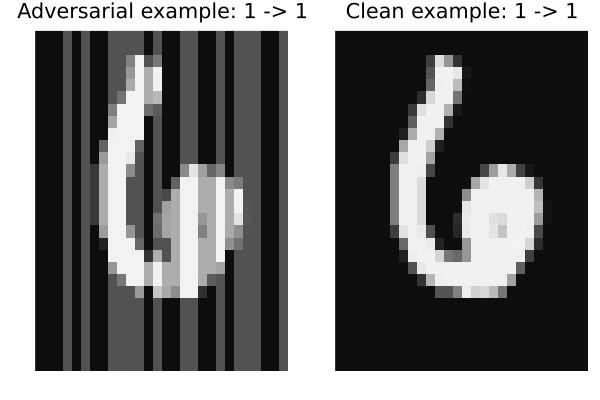

In [103]:
idx = 8
difference = x_best[:, :, :, idx] - X_lol[:, :, :, idx]
plot_mnist_image(x_best[:, :, :, idx], X_lol[:, :, :, idx], 1, 1, 1)